In [1]:
%cd ~/bench

/home/soda/rcappuzz/work/benchmark-join-suggestions


In [2]:
%load_ext autoreload
%autoreload 2
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import matplotlib.colors as mcolors
import src.utils.plotting as plotting
from src.utils.logging import read_logs
from matplotlib.gridspec import GridSpec

import tarfile
import json
import pandas as pd 
cfg = pl.Config()
cfg.set_fmt_str_lengths(150)

polars.config.Config

# Combine all results 

In [3]:
root_path = Path("results/big_batch")
df_list = []
for rpath in root_path.iterdir():
    df_raw = read_logs(exp_name=None, exp_path=rpath)
    df_list.append(df_raw)

df_results = pl.concat(df_list)

# BIG BATCH

In [4]:
df_ = df_results.select(
    pl.col(
        [
            "scenario_id",
            "target_dl",
            "jd_method",
            "base_table",
            "estimator",
            "chosen_model",
            "aggregation",
            "r2score",
            "time_fit",
            "time_predict",
            "time_run",
            "epsilon",
        ]
    )
).filter(
    (~pl.col("base_table").str.contains("open_data"))
    & (pl.col("target_dl") != "wordnet_big")
)

In [5]:
df_ = df_.with_columns(
    (pl.col("jd_method") + " | " + pl.col("target_dl")).alias("case")
)

In [6]:
col_order = (
    df_.select(pl.col("base_table")).unique().sort("base_table").to_series().to_list()
)

In [7]:
df_ = df_.group_by(
    ["target_dl", "jd_method", "base_table", "estimator", "chosen_model"]
).map_groups(lambda x: x.with_row_count("fold_id"))

In [8]:
joined = df_.join(
    df_.filter(pl.col("estimator") == "nojoin"),
    on=["target_dl", "jd_method", "base_table", "chosen_model", "fold_id"],
    how="left",
).with_columns((pl.col("r2score") - pl.col("r2score_right")).alias("difference"))

In [9]:
results_full = joined.filter(~pl.col("base_table").str.contains("depleted"))
results_depleted = joined.filter(pl.col("base_table").str.contains("depleted"))

In [10]:
max_diff_full = results_full.select(pl.col("difference").abs().max()).item()
max_diff_full = results_full.with_columns(
    (pl.col("difference") / max_diff_full).alias("scaled_diff")
)
max_diff_depleted = results_depleted.select(pl.col("difference").abs().max()).item()
results_depleted = results_depleted.with_columns(
    (pl.col("difference") / max_diff_depleted).alias("scaled_diff")
)

results_full = results_full.with_columns(
    (pl.col("difference") / max_diff_depleted).alias("scaled_diff")
)

results_depleted = results_depleted.with_columns(
    (pl.col("difference") / max_diff_depleted).alias("scaled_diff")
)

In [11]:
current_results = results_depleted.clone()

# Post-hoc

In [12]:
current_results = current_results.with_columns(
    (pl.col("difference") / max_diff_depleted).alias("scaled_diff")
)

In [13]:
current_results.head()

fold_id,scenario_id,target_dl,jd_method,base_table,estimator,chosen_model,aggregation,r2score,time_fit,time_predict,time_run,epsilon,case,scenario_id_right,estimator_right,aggregation_right,r2score_right,time_fit_right,time_predict_right,time_run_right,epsilon_right,case_right,difference,scaled_diff
u32,i64,str,str,str,str,str,str,f64,f64,f64,f64,f64,str,i64,str,str,f64,f64,f64,f64,f64,str,f64,f64
0,44,"""binary_update""","""exact_matching""","""company-employees-yadl-depleted""","""nojoin""","""linear""","""first""",-0.001172,0.009954,0.004452,0.014944,null,"""exact_matching | binary_update""",44,"""nojoin""","""first""",-0.001172,0.009954,0.004452,0.014944,null,"""exact_matching | binary_update""",0.0,0.0
1,44,"""binary_update""","""exact_matching""","""company-employees-yadl-depleted""","""nojoin""","""linear""","""first""",-0.000002,0.018883,0.004556,0.023986,null,"""exact_matching | binary_update""",44,"""nojoin""","""first""",-0.000002,0.018883,0.004556,0.023986,null,"""exact_matching | binary_update""",0.0,0.0
2,44,"""binary_update""","""exact_matching""","""company-employees-yadl-depleted""","""nojoin""","""linear""","""first""",-0.000003,0.015183,0.004213,0.019946,null,"""exact_matching | binary_update""",44,"""nojoin""","""first""",-0.000003,0.015183,0.004213,0.019946,null,"""exact_matching | binary_update""",0.0,0.0
3,44,"""binary_update""","""exact_matching""","""company-employees-yadl-depleted""","""nojoin""","""linear""","""first""",-0.0083,0.009395,0.004178,0.014065,null,"""exact_matching | binary_update""",44,"""nojoin""","""first""",-0.0083,0.009395,0.004178,0.014065,null,"""exact_matching | binary_update""",0.0,0.0
4,44,"""binary_update""","""exact_matching""","""company-employees-yadl-depleted""","""nojoin""","""linear""","""first""",-0.001374,0.009355,0.004211,0.014062,null,"""exact_matching | binary_update""",44,"""nojoin""","""first""",-0.001374,0.009355,0.004211,0.014062,null,"""exact_matching | binary_update""",0.0,0.0


In [14]:
# Top 5 scores overall
current_results.group_by(["target_dl", "jd_method", "estimator", "chosen_model"]).agg(
    pl.mean("scaled_diff").alias("avg_scaled_diff"),
    pl.std("scaled_diff").alias("std_scaled_diff"),
).top_k(k=5, by="avg_scaled_diff")

target_dl,jd_method,estimator,chosen_model,avg_scaled_diff,std_scaled_diff
str,str,str,str,f64,f64
"""binary_update""","""exact_matching""","""stepwise_greedy_join""","""catboost""",0.513866,0.302553
"""binary_update""","""exact_matching""","""full_join""","""catboost""",0.511494,0.302724
"""wordnet_full_flat""","""exact_matching""","""stepwise_greedy_join""","""catboost""",0.486717,0.346504
"""wordnet_full_flat""","""exact_matching""","""full_join""","""catboost""",0.48388,0.350774
"""wordnet_full_flat""","""exact_matching""","""best_single_join""","""catboost""",0.461891,0.367982


For each variable, I am going to find the best configuration on averge, then fix that value for comparison in other plots. 

In [15]:
best_value = {}
for v in ["target_dl", "jd_method", "estimator", "chosen_model"]:
    this_best = (
        current_results.group_by(v)
        .agg(
            pl.mean("scaled_diff").alias("avg_scaled_diff"),
        )
        .top_k(k=5, by="avg_scaled_diff")
    )
    best_value[v] = this_best.top_k(1, by="avg_scaled_diff")[v].item()
    display(this_best)

target_dl,avg_scaled_diff
str,f64
"""wordnet_full_flat""",0.241706
"""binary_update""",0.204701


jd_method,avg_scaled_diff
str,f64
"""exact_matching""",0.276931
"""minhash""",0.169476


estimator,avg_scaled_diff
str,f64
"""full_join""",0.339585
"""stepwise_greedy_join""",0.336955
"""best_single_join""",0.253873
"""highest_containment""",0.185604
"""nojoin""",0.0


chosen_model,avg_scaled_diff
str,f64
"""catboost""",0.262856
"""linear""",0.18355


In [16]:
best_value

{'target_dl': 'wordnet_full_flat',
 'jd_method': 'exact_matching',
 'estimator': 'full_join',
 'chosen_model': 'catboost'}

### Variable: Target DL

In [17]:
def prepare_data(df, target_variable):
    values = (
        df.filter(pl.col("estimator") != "nojoin")
        .with_columns(
            pl.col("estimator").cast(pl.Categorical).to_physical().alias("est_cat")
        )
        .group_by(target_variable)
        .agg(pl.all())
        .select(
            pl.col(target_variable),
            pl.col("scaled_diff"),
            pl.col("estimator"),
            pl.col("est_cat"),
        )
    )
    values_dict = values.to_dict()
    data = [np.array(arr) for arr in values_dict["scaled_diff"]]
    label_mapping = (
        df.filter(pl.col("estimator") != "nojoin")
        .select(
            pl.col("estimator").cast(pl.Categorical).cat.get_categories().alias("label")
        )
        .with_row_count("idx")
        .to_dict()
    )
    return data, values_dict, label_mapping

In [18]:
target_variable = "jd_method"
data, values_dict, label_mapping = prepare_data(current_results, target_variable)

In [19]:
# Function to add jitter to data
def add_jitter(data, factor=0.1):
    return data + np.random.normal(0, factor, len(data))


jitter_factor = 0.05

In [20]:
def violin_plot_with_hist(data, values_dict, label_mapping, target_variable):
    # Use the Set3 colormap for 4 distinct colors
    colors = plt.cm.Set1(np.arange(4))

    fig, axes = plt.subplots(
        nrows=1,
        ncols=4,
        sharey=True,
        gridspec_kw={"width_ratios": [2.5, 1, 2.5, 1]},
        figsize=(8, 5),
        layout="constrained",
    )
    ax_big = fig.add_subplot(111, frameon=False)
    # gs = GridSpec(1, 4, width_ratios=[3, 1, 3, 1])
    ax_big.spines["top"].set_color("none")
    ax_big.spines["bottom"].set_color("none")
    ax_big.spines["left"].set_color("none")
    ax_big.spines["right"].set_color("none")
    ax_big.tick_params(
        labelcolor="none", top=False, bottom=False, left=False, right=False
    )

    for idx, d in enumerate(data):
        ax_violin = axes[idx * 2]
        ax_hist = axes[idx * 2 + 1]

        parts = ax_violin.violinplot(d, showmedians=False, showmeans=False)
        ax_violin.set_xticks([1], labels=[values_dict[target_variable][idx]])
        quartile1, medians, quartile3 = np.percentile(d, [25, 50, 75])
        ax_violin.scatter(
            [1], medians, marker="o", color="white", s=30, zorder=3, edgecolors="black"
        )
        # ax_violin.hlines(medians, 0, 1)
        ax_violin.annotate(
            f"{medians:.2f}",
            xy=(-0.1, medians),
            xycoords=("axes fraction", "data"),
            size="x-small",
            color="blue",
        )
        ax_violin.axhline(medians, alpha=0.7, zorder=2, color="blue")

        color_variable = values_dict["est_cat"][idx]

        ax_violin.scatter(
            add_jitter(np.ones_like(d), jitter_factor),
            d,
            alpha=0.7,
            marker="o",
            s=5,
            c=colors[color_variable],
        )

        arrs = [
            np.array(d[values_dict["est_cat"][idx] == e_case])
            for e_case in label_mapping["idx"]
        ]
        h_colors = [colors[e_case] for e_case in label_mapping["idx"]]
        ax_hist.hist(
            arrs,
            bins=50,
            orientation="horizontal",
            histtype="stepfilled",
            color=h_colors,
            alpha=0.5,
            label=label_mapping["label"],
            # density=True,
            # weights=np.ones_like(subset)/len(subset),
            stacked=True,
        )
        h, l = ax_hist.get_legend_handles_labels()

        ax_violin.axhline(0, alpha=0.4, zorder=0, color="gray")
    fig.legend(h, l, loc="outside upper right")
    fig.suptitle(target_variable)
    ax_big.set_ylabel("Difference from No Join")
    # plt.tight_layout()

In [21]:
def violin_plot(data, values_dict, label_mapping, target_variable, jitter_factor=0.05):
    # Use the Set3 colormap for 4 distinct colors
    colors = plt.cm.viridis(np.linspace(0, 1, 4))
    color_mapping = dict(
        zip(
            [
                "highest_containment",
                "best_single_join",
                "full_join",
                "stepwise_greedy_join",
            ],
            colors,
        )
    )
    # colors = plt.cm.viridis(np.arange(4))

    fig, axes = plt.subplots(
        nrows=2,
        ncols=1,
        sharex=True,
        # gridspec_kw={"width_ratios": [2.5, 1, 2.5, 1]},
        figsize=(6, 3),
        layout="tight",
    )
    ax_big = fig.add_subplot(111, frameon=False)
    ax_big.spines["top"].set_color("none")
    ax_big.spines["bottom"].set_color("none")
    ax_big.spines["left"].set_color("none")
    ax_big.spines["right"].set_color("none")
    ax_big.tick_params(
        labelcolor="none", top=False, bottom=False, left=False, right=False
    )

    for idx, d in enumerate(data):
        ax_violin = axes[idx]
        print(values_dict[target_variable][idx])
        # ax_violin.axhline(0, alpha=0.4, zorder=0, color="gray")

        parts = ax_violin.violinplot(d, showmedians=False, showmeans=False, vert=False)
        quartile1, medians, quartile3 = np.percentile(d, [25, 50, 75])
        ax_violin.scatter(
            medians, [1], marker="o", color="white", s=30, zorder=3, edgecolors="black"
        )
        ax_violin.annotate(
            f"{medians:.2f}",
            xy=(medians, -0.1),
            xycoords=(
                "data",
                "axes fraction",
            ),
            size="x-small",
            color="blue",
        )
        ax_violin.axvline(medians, alpha=0.7, zorder=2, color="blue")

        color_variable = values_dict["est_cat"][idx]

        for label in label_mapping["label"]:
            masked = d[values_dict["estimator"][idx] == label]
            ax_violin.scatter(
                masked,
                add_jitter(np.ones_like(masked), jitter_factor),
                color=color_mapping[label],
                marker="o",
                s=3,
                alpha=0.7,
                label=label,
            )
        # ax_violin.scatter(
        #     d,
        #     add_jitter(np.ones_like(d), jitter_factor),
        #     alpha=0.7,
        #     marker="o",
        #     s=2,
        #     c=colors[color_variable],
        # )
        ax_violin.set_yticks([1], labels=[values_dict[target_variable][idx]])
    h, l = ax_violin.get_legend_handles_labels()
    fig.legend(h, l, loc="outside upper right")
    fig.suptitle(target_variable)
    ax_big.set_xlabel("Difference from No Join")
    plt.tight_layout()

In [53]:
cases = (
    current_results.select(pl.col(["jd_method", "chosen_model"]).unique().implode())
    .transpose(include_header=True)
    .to_dict(as_series=False)
)

cases = dict(zip(*list(cases.values())))

In [54]:
import itertools

sum(1 for _ in itertools.product(*cases.values()))

4

In [104]:
current_results.group_by(pl.col("estimator")).agg(pl.mean("scaled_diff")).select(
    pl.col("estimator").unique()
).to_numpy().squeeze()

array(['nojoin', 'highest_containment', 'best_single_join', 'full_join',
       'stepwise_greedy_join'], dtype=object)

In [154]:
def violin_plot_case(
    ax, df, scatterplot_variable, scatterplot_mapping, jitter_factor=0.07
):
    group_keys = ["jd_method", "estimator", "chosen_model", "target_dl", "base_table"]
    data = df["scaled_diff"].to_numpy()
    ax_violin = ax
    ax_violin.axvline(0, alpha=0.4, zorder=0, color="gray")

    parts = ax_violin.violinplot(
        data,
        showmedians=False,
        showmeans=False,
        vert=False,
    )
    for pc in parts["bodies"]:
        pc.set_edgecolor("black")
        pc.set_facecolor("none")
        pc.set_alpha(1)
        pc.set_linewidth(1)
        pc.set_zorder(2.5)

    quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75])
    ax_violin.scatter(
        medians, [1], marker="o", color="white", s=30, zorder=3, edgecolors="black"
    )
    ax_violin.annotate(
        f"{medians:.2f}",
        xy=(medians, -0.2),
        xycoords=(
            "data",
            "axes fraction",
        ),
        size="x-small",
        color="blue",
    )
    ax_violin.axvline(medians, alpha=0.7, zorder=2, color="blue")

    for label in scatterplot_mapping:
        # values = df.filter(pl.col(scatterplot_variable) == label)["scaled_diff"].to_numpy()
        values = (
            df.filter(pl.col(scatterplot_variable) == label)
            .group_by(group_keys)
            .agg(pl.mean("scaled_diff"))["scaled_diff"]
            .to_numpy()
        )
        ax_violin.scatter(
            values,
            add_jitter(np.ones_like(values), jitter_factor),
            color=scatterplot_mapping[label],
            marker="o",
            s=30,
            alpha=0.7,
            label=label,
            zorder=0,
        )
    h, l = ax_violin.get_legend_handles_labels()
    return h, l

In [155]:
def add_subplot(fig, position):
    new_ax = fig.add_subplot(*position, frameon=False)

    new_ax.spines["top"].set_color("none")
    new_ax.spines["bottom"].set_color("none")
    new_ax.spines["left"].set_color("none")
    new_ax.spines["right"].set_color("none")
    new_ax.tick_params(
        labelcolor="none", top=False, bottom=False, left=False, right=False
    )
    return new_ax

exact_matching
chosen_model
catboost
linear
minhash
chosen_model
catboost
linear


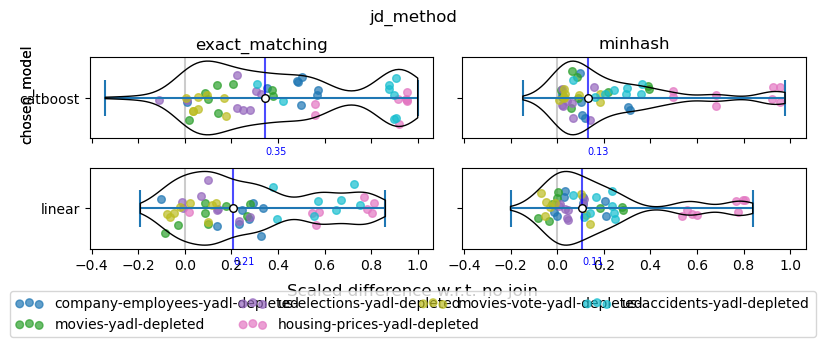

In [160]:
def draw_plot(
    cases,
    outer_variable,
    current_results,
    scatterplot_variable="estimator",
    colormap_name="viridis",
):
    group_keys = ["jd_method", "estimator", "chosen_model", "target_dl", "base_table"]
    inner_variables = [_ for _ in cases.keys() if _ != outer_variable]
    n_cols = len(cases[outer_variable])
    n_rows = sum(len(cases[var]) for var in inner_variables)

    fig, axes = plt.subplots(
        nrows=n_rows,
        ncols=n_cols,
        figsize=(8, 3),
        sharex=True,
        sharey="row",
        layout="constrained",
    )

    ax_big = add_subplot(fig, (1, 1, 1))

    unique_target = (
        current_results.group_by(pl.col(scatterplot_variable))
        .agg(pl.mean("scaled_diff"))
        .select(pl.col(scatterplot_variable).unique())
        .to_numpy()
        .squeeze()
    )
    colors = plt.colormaps[colormap_name](np.linspace(0, 1, len(unique_target)))
    # colors = plt.cm.viridis(np.linspace(0, 1, len(unique_target)))
    scatterplot_mapping = dict(
        zip(
            unique_target,
            colors,
        )
    )

    for idx_outer_var, c_m in enumerate(cases[outer_variable]):
        print(c_m)
        for idx_inner_var, tg in enumerate(inner_variables):
            new_ax = add_subplot(fig, (2, 1, idx_inner_var + 1))
            new_ax.set_ylabel(tg)
            new_ax.yaxis.set_label_position("left")
            print(tg)
            for idx_plot, c_inner in enumerate(cases[tg]):
                print(c_inner)
                ax = axes[2 * idx_inner_var + idx_plot, idx_outer_var]
                ax.annotate(c_inner + c_m, xy=(0, 0))
                filter_dict = {outer_variable: c_m, tg: c_inner}
                # subset = current_results.filter(**filter_dict).group_by(group_keys).agg(pl.mean("scaled_diff"))
                subset = current_results.filter(**filter_dict)
                h, l = violin_plot_case(
                    ax, subset, scatterplot_variable, scatterplot_mapping
                )
                ax.set_yticks([1], [c_inner])
        axes[0][idx_outer_var].set_title(c_m)
    # for ax, col in zip(axes[0], cols):
    #     ax.set_title(col)
    fig.legend(
        h,
        l,
        loc="outside lower left",
        mode="expand",
        ncols=4,
        markerscale=1,
        borderaxespad=-0.2,
        bbox_to_anchor=(0, -0.1, 1, 0.5),
        scatterpoints=3,
    )
    fig.set_constrained_layout_pads(
        w_pad=5.0 / 72.0, h_pad=4.0 / 72.0, hspace=0.0 / 72.0, wspace=0.0 / 72.0
    )
    fig.suptitle(outer_variable)
    fig.supxlabel("Scaled difference w.r.t. no join")

    # fig.tight_layout()
    # ax_big.legend(h,l)


draw_plot(
    cases,
    "jd_method",
    current_results.filter(pl.col("estimator") != "nojoin"),
    scatterplot_variable="base_table",
    colormap_name="tab10",
)
# draw_plot(cases,"jd_method", current_results, scatterplot_variable="base_table", colormap_name="tab10")

exact_matching
chosen_model
catboost
linear
minhash
chosen_model
catboost
linear
catboost
jd_method
exact_matching
minhash
linear
jd_method
exact_matching
minhash


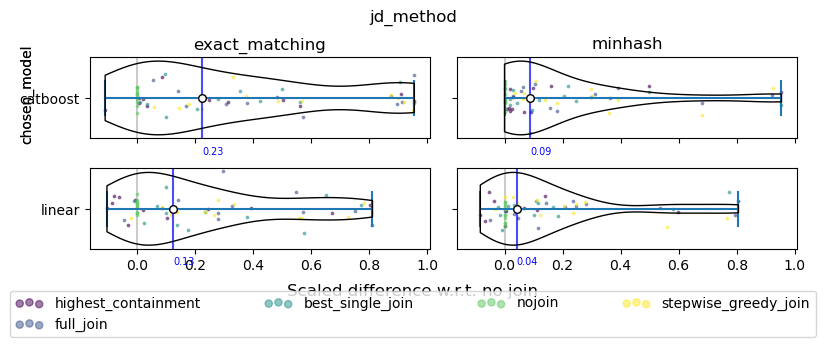

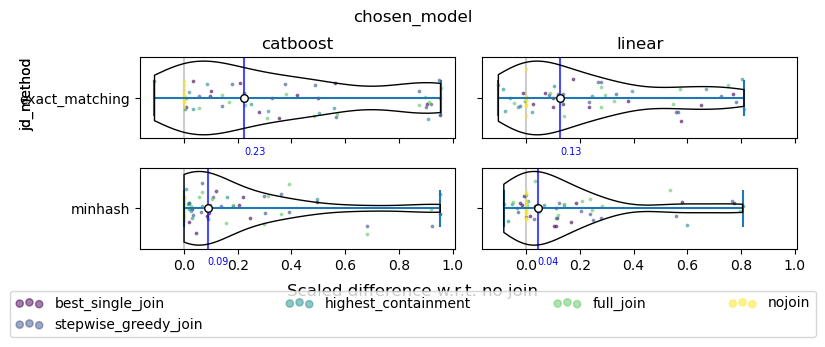

In [116]:
for outer_variable in cases:
    draw_plot(cases, outer_variable, current_results)

catboost
jd_method
exact_matching
minhash
linear
jd_method
exact_matching
minhash


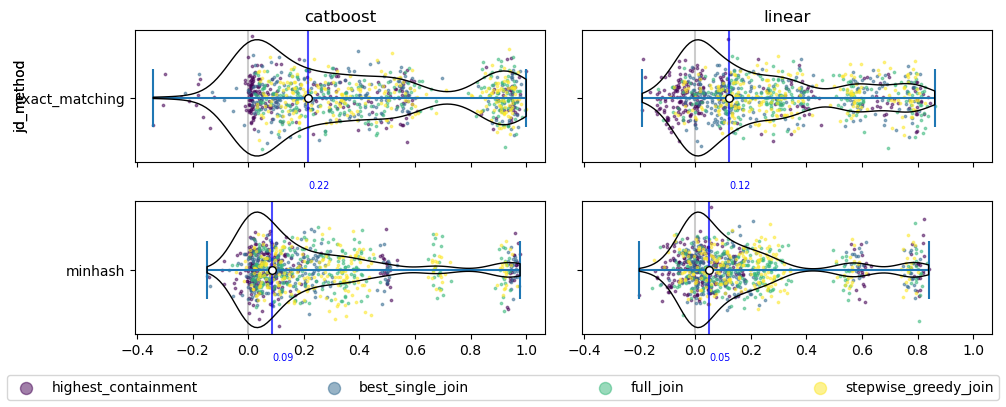

In [59]:
# fig, axes = plt.subplots(4,4, sharex=True)
outer_variable = "chosen_model"
inner_variables = [_ for _ in cases.keys() if _ != outer_variable]
n_cols = len(cases[outer_variable])
n_rows = sum(len(cases[var]) for var in inner_variables)

fig, axes = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(10, 4),
    sharex=True,
    sharey="row",
    layout="constrained",
)

ax_big = add_subplot(fig, (1, 1, 1))

for idx_outer_var, c_m in enumerate(cases[outer_variable]):
    print(c_m)
    for idx_inner_var, tg in enumerate(inner_variables):
        new_ax = add_subplot(fig, (2, 1, idx_inner_var + 1))
        new_ax.set_ylabel(tg)
        new_ax.yaxis.set_label_position("left")
        print(tg)
        for idx_plot, c_inner in enumerate(cases[tg]):
            print(c_inner)
            ax = axes[2 * idx_inner_var + idx_plot, idx_outer_var]
            ax.annotate(c_inner + c_m, xy=(0, 0))
            filter_dict = {outer_variable: c_m, tg: c_inner}
            subset = current_results.filter(**filter_dict)
            h, l = violin_plot_case(ax, subset, None)
            ax.set_yticks([1], [c_inner])
    axes[0][idx_outer_var].set_title(c_m)
# for ax, col in zip(axes[0], cols):
#     ax.set_title(col)
fig.legend(h, l, loc="outside lower left", mode="expand", ncols=4, markerscale=5)
fig.set_constrained_layout_pads(
    w_pad=8.0 / 72.0, h_pad=4.0 / 72.0, hspace=0.0 / 72.0, wspace=0.0 / 72.0
)

# fig.tight_layout()
# ax_big.legend(h,l)

In [60]:
subset.select(pl.col(["jd_method", "chosen_model"]).unique().implode()).transpose(
    include_header=True
).to_dict(as_series=False)

{'column': ['jd_method', 'chosen_model'],
 'column_0': [['minhash'], ['linear']]}

exact_matching
minhash
linear
catboost


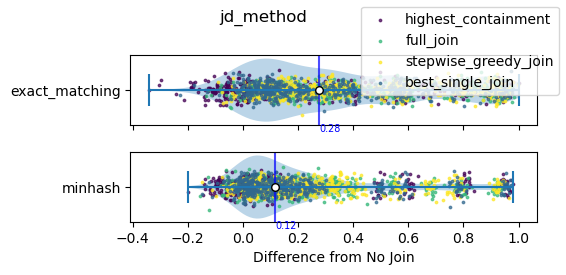

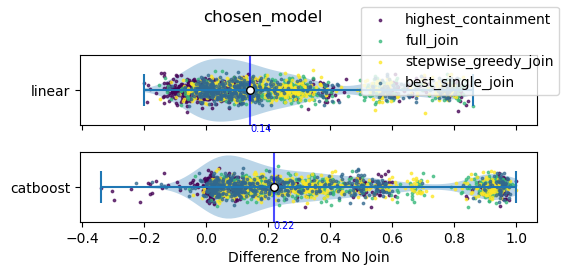

In [61]:
target_variable = "jd_method"
for tg in ["jd_method", "chosen_model"]:
    data, values_dict, label_mapping = prepare_data(results_depleted, tg)
    violin_plot(data, values_dict, label_mapping, tg)
    # break

In [62]:
from itertools import combinations

In [63]:
best_value

{'target_dl': 'wordnet_full_flat',
 'jd_method': 'exact_matching',
 'estimator': 'full_join',
 'chosen_model': 'catboost'}

In [64]:
list(combinations(best_value.items(), 3))

[(('target_dl', 'wordnet_full_flat'),
  ('jd_method', 'exact_matching'),
  ('estimator', 'full_join')),
 (('target_dl', 'wordnet_full_flat'),
  ('jd_method', 'exact_matching'),
  ('chosen_model', 'catboost')),
 (('target_dl', 'wordnet_full_flat'),
  ('estimator', 'full_join'),
  ('chosen_model', 'catboost')),
 (('jd_method', 'exact_matching'),
  ('estimator', 'full_join'),
  ('chosen_model', 'catboost'))]

In [65]:
for comb in combinations(best_value.items(), 2):
    case1, case2 = comb
    t_f = current_results.filter(
        (pl.col(case1[0]) == case1[1]) & (pl.col(case1[0]) == case1[1])
    )

In [66]:
for tg in ["jd_method", "chosen_model", "estimator"]:
    filter_values = [(k, v) for k, v in best_value.items() if k != tg]
    c1, c2, c3 = filter_values
    t_f = current_results.filter(
        (pl.col(c1[0]) == c1[1]) & (pl.col(c2[0]) == c2[1]) & (pl.col(c3[0]) == c3[1])
    )

    # fig, ax = plt.subplots(1)
    # sns.violinplot(data=t_f.to_pandas(), x="scaled_diff", y=tg, ax=ax)

# Effect of pipeline steps 

In [67]:
best_value = {}
worst_value = {}
for v in ["jd_method", "estimator", "chosen_model"]:
    this_best = (
        current_results.filter(pl.col("estimator") != "nojoin")
        .group_by(v)
        .agg(
            pl.mean("scaled_diff").alias("avg_scaled_diff"),
        )
        .top_k(k=5, by="avg_scaled_diff")
    )
    best_value[v] = this_best.top_k(1, by="avg_scaled_diff")[v].item()
    worst_value[v] = this_best.bottom_k(1, by="avg_scaled_diff")[v].item()
    display(this_best)

jd_method,avg_scaled_diff
str,f64
"""exact_matching""",0.346163
"""minhash""",0.211845


estimator,avg_scaled_diff
str,f64
"""full_join""",0.339585
"""stepwise_greedy_join""",0.336955
"""best_single_join""",0.253873
"""highest_containment""",0.185604


chosen_model,avg_scaled_diff
str,f64
"""catboost""",0.328571
"""linear""",0.229438


In [68]:
# Top 5 scores overall
comb_results = (
    current_results.group_by(["jd_method", "estimator", "chosen_model"])
    .agg(
        pl.mean("scaled_diff").alias("avg_scaled_diff"),
        pl.std("scaled_diff").alias("std_scaled_diff"),
    )
    .sort("avg_scaled_diff", descending=True)
    .filter(pl.col("estimator") != "nojoin")
)

In [69]:
worst_value

{'jd_method': 'minhash',
 'estimator': 'highest_containment',
 'chosen_model': 'linear'}

In [70]:
comb_results.filter(**worst_value)["avg_scaled_diff"].item()

0.1273233617413864

In [71]:
current_value = dict(worst_value)
all_values = [current_value]
for k, v in best_value.items():
    new_value = dict(current_value)
    new_value.update({k: v})
    all_values.append(new_value)
    current_value = new_value

In [72]:
vals_to_plot = []
for data in all_values:
    vals_to_plot.append(comb_results.filter(**data))

In [73]:
pl.concat(vals_to_plot).select(pl.col("avg_scaled_diff").diff())

avg_scaled_diff
f64
null
0.028273
0.192589
0.149501


In [76]:
df_waterfall = (
    pl.concat(vals_to_plot)
    .with_columns(
        (
            pl.col("jd_method")
            + "\n"
            + pl.col("estimator")
            + "\n"
            + pl.col("chosen_model")
        ).alias("case")
    )
    .select(pl.col("case"), pl.col("avg_scaled_diff").alias("value"))
)

In [77]:
_t = df_waterfall.with_columns(
    pl.col("value").alias("bottom").shift(1).fill_null(0),
    pl.col("value").diff().alias("diff").fill_null(pl.col("value")),
).to_pandas()

In [78]:
_t = (
    df_waterfall.with_columns(
        pl.col("value").alias("bottom").shift(1).fill_null(0),
        pl.col("value").diff().alias("diff").fill_null(pl.col("value")),
    )
    .with_columns(
        pl.col("diff").cumsum().alias("fill"),
    )
    .to_pandas()
)

In [79]:
_t

,case,value,bottom,diff,fill
0,minhash\nhighest_containment\nlinear,0.127323,0.000000,0.127323,0.127323
1,exact_matching\nhighest_containment\nlinear,0.155597,0.127323,0.028273,0.155597
2,exact_matching\nfull_join\nlinear,0.348186,0.155597,0.192589,0.348186
3,exact_matching\nfull_join\ncatboost,0.497687,0.348186,0.149501,0.497687


Text(0.5, 0, 'Difference wtr nojoin')

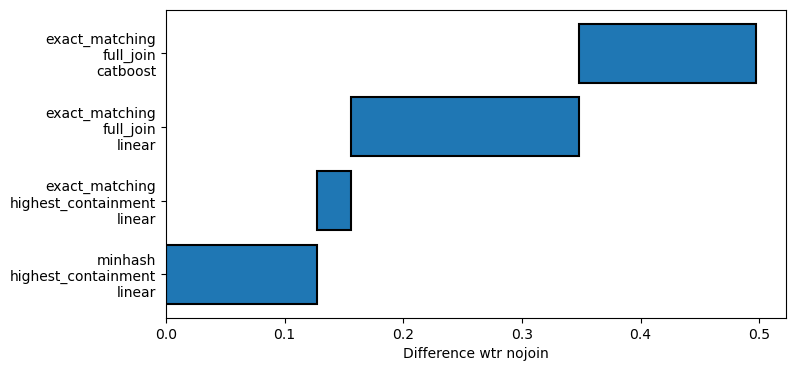

In [157]:
# plt.bar(bottom="bottom",height="diff", x="case", data=_t)
fig, ax = plt.subplots(1, figsize=(8, 4))

# p = ax.barh(
#     width="value", y="case", data=_t, edgecolor="black", linewidth=1.5, color="green"
# )
# ax.bar_label(p, [f"{_:.2f}" for _ in _t["value"]])
# ax.barh(
#     width="bottom", y="case", data=_t, edgecolor="black", linewidth=1.5, color="red"
# )


# MINE
ax.barh(
    left="bottom", width="diff", y="case", data=_t, edgecolor="black", linewidth=1.5
)


# step = (
#     pl.from_pandas(_t)
#     .select(pl.col("bottom").repeat_by(3).list.explode())
#     .shift(-1)
#     .to_numpy()
# )
# step[1::3] = np.nan
# mask = np.repeat(
#     np.arange(5),
#     3,
# )
# plt.plot(step, mask, color="black", zorder=2, linewidth=1)
ax.set_xlabel("Difference wtr nojoin")

In [81]:
current_results.head()

fold_id,scenario_id,target_dl,jd_method,base_table,estimator,chosen_model,aggregation,r2score,time_fit,time_predict,time_run,epsilon,case,scenario_id_right,estimator_right,aggregation_right,r2score_right,time_fit_right,time_predict_right,time_run_right,epsilon_right,case_right,difference,scaled_diff
u32,i64,str,str,str,str,str,str,f64,f64,f64,f64,f64,str,i64,str,str,f64,f64,f64,f64,f64,str,f64,f64
0,44,"""binary_update""","""exact_matching""","""company-employees-yadl-depleted""","""nojoin""","""linear""","""first""",-0.001172,0.009954,0.004452,0.014944,null,"""exact_matching | binary_update""",44,"""nojoin""","""first""",-0.001172,0.009954,0.004452,0.014944,null,"""exact_matching | binary_update""",0.0,0.0
1,44,"""binary_update""","""exact_matching""","""company-employees-yadl-depleted""","""nojoin""","""linear""","""first""",-0.000002,0.018883,0.004556,0.023986,null,"""exact_matching | binary_update""",44,"""nojoin""","""first""",-0.000002,0.018883,0.004556,0.023986,null,"""exact_matching | binary_update""",0.0,0.0
2,44,"""binary_update""","""exact_matching""","""company-employees-yadl-depleted""","""nojoin""","""linear""","""first""",-0.000003,0.015183,0.004213,0.019946,null,"""exact_matching | binary_update""",44,"""nojoin""","""first""",-0.000003,0.015183,0.004213,0.019946,null,"""exact_matching | binary_update""",0.0,0.0
3,44,"""binary_update""","""exact_matching""","""company-employees-yadl-depleted""","""nojoin""","""linear""","""first""",-0.0083,0.009395,0.004178,0.014065,null,"""exact_matching | binary_update""",44,"""nojoin""","""first""",-0.0083,0.009395,0.004178,0.014065,null,"""exact_matching | binary_update""",0.0,0.0
4,44,"""binary_update""","""exact_matching""","""company-employees-yadl-depleted""","""nojoin""","""linear""","""first""",-0.001374,0.009355,0.004211,0.014062,null,"""exact_matching | binary_update""",44,"""nojoin""","""first""",-0.001374,0.009355,0.004211,0.014062,null,"""exact_matching | binary_update""",0.0,0.0


In [82]:
target_variable = "jd_method"
target_method = "exact_matching"

projection = [
    "fold_id",
    "target_dl",
    "jd_method",
    "estimator",
    "chosen_model",
    "r2score",
    "scaled_diff",
]

_prep = (
    current_results.select(projection)
    .join(
        current_results.select(projection),
        on=["estimator", "chosen_model", "fold_id"],
    )
    .filter(
        (pl.col("jd_method") == target_method)
        & (pl.col("jd_method") != pl.col("jd_method_right"))
    )
    .with_columns(
        (pl.col("scaled_diff") - pl.col("scaled_diff_right")).alias("diff_methods")
    )
)

In [182]:
cases

{'jd_method': ['exact_matching', 'minhash'],
 'chosen_model': ['catboost', 'linear']}

In [180]:
_prep = (
    current_results.filter(pl.col("jd_method") != "minhash")
    .select(projection)
    .join(
        current_results.select(projection)
        .group_by(["jd_method", "chosen_model", "fold_id"])
        .agg(pl.mean("r2score").alias("avg_r2score")),
        on=["jd_method", "chosen_model", "fold_id"],
    )
    .with_columns((pl.col("r2score") - pl.col("avg_r2score")).alias("diff_from_mean"))
    .select("estimator", "diff_from_mean")
    .group_by("estimator", maintain_order=True)
    .agg(pl.all(), pl.mean("diff_from_mean").alias("avg_diff"))
    .sort("avg_diff")
    .drop("avg_diff")
    .to_dict()
    # .to_pandas()
)
data = dict(zip(*list(_prep.values())))

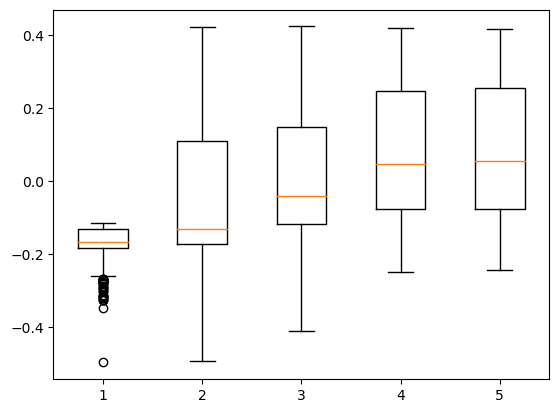

In [181]:
_ = plt.boxplot(x=data.values())